# MLP-100 For Digit Recognition on MNIST

**Architecture: 784-FC:100-FC:100-10**

Here, 
- FC: Fully connected layer with ReLU activation

**Naming Conventions**
- Small letter variables are local to a section
- Capitalized variables are used across sections
- Functions are always assumed to be used across sections

# Environment Setup

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.1  Device: cuda


# Loading Dataset

Dataset will be downloaded using PyTorch into a local directory.

In [2]:
data_path = "./dataset"

Train_dataset = datasets.MNIST(data_path, 
                               train=True, 
                               download=True, 
                               transform=transforms.ToTensor())

Test_dataset = datasets.MNIST(data_path, 
                              train=False, 
                              transform=transforms.ToTensor())

# Explore Dataset to Understand

Note: 
- MNIST data items are a tuple of image and a label. 
- The image is a tensor of dimension (1, 28, 28). The first axis is probably for the image channel. As it is a grayscale image, there is only one channel.
- The label is a number corresponding to the image.

In [3]:
# Check out an item
item = Train_dataset[0]
print('item:', type(item), '  len:', len(item))
print('item[0]:', type(item[0]), '  item[1]:', type(item[1]))
print('item[0]:', item[0].size())

img = item[0].flatten()
print('')
print('min:', torch.min(img))
print('max:', torch.max(img))
print('avg:', torch.mean(img))

item: <class 'tuple'>   len: 2
item[0]: <class 'torch.Tensor'>   item[1]: <class 'int'>
item[0]: torch.Size([1, 28, 28])

min: tensor(0.)
max: tensor(1.)
avg: tensor(0.1377)


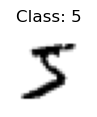

In [4]:
# Show an example data item
def showItem(item, newfig=True):
    if newfig: plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(item[0].numpy().reshape(28,28), cmap="gray_r")
    plt.title(f'Class: {item[1]}')

    
showItem(item, newfig=True)

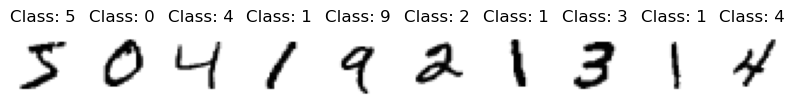

In [5]:
# Show a few more items
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    item = Train_dataset[i]
    plt.subplot(1,10,i+1)
    showItem(item, newfig=False)

# Trim Down Dataset

If needed, trim down the dataset here for faster experimentation

In [6]:
print('Train:', len(Train_dataset))
print('Test :', len(Test_dataset))

Train: 60000
Test : 10000


# Define Features and Labels

The features for this MLP100 model are selected to be the raw image pixels. The image is flattened into a 1-D tensor to create the feature vector.

In [7]:
# Given a data item, returns the features
def extract_feature(item):
    return item[0].flatten()


# Compute the feature length
item = Train_dataset[0]
feat = extract_feature(item)
Feature_length = len(feat)

print('feat:', feat.size())
print('Feature_length:', Feature_length)

feat: torch.Size([784])
Feature_length: 784


In [8]:
# Get the labels
all_labels = set()
for item in tqdm(Train_dataset):
    all_labels.add(item[1])

Labels = sorted(list(all_labels))
print('Labels:', Labels)

  0%|          | 0/60000 [00:00<?, ?it/s]

Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


# Define Model

In [9]:
# Define an MLP with single hiddend layer with 12 units and ReLU activation.
class MLP100(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP100, self).__init__()
        # Save parameters
        self.input_size = input_size
        self.num_classes = num_classes
        self.debug = False    # can be used to activate debugging features
        # Define layers
        self.fc1 = nn.Linear(input_size, 100)   # 100 hidden units
        self.fc1_drop = nn.Dropout(0.2)         # drop-out for faster training, has no effect on inference
        self.fc2 = nn.Linear(100, 100)          # 100 hidden units
        self.fc2_drop = nn.Dropout(0.2)         # drop-out for faster training, has no effect on inference
        self.fc3 = nn.Linear(100, num_classes)  # output layer

    # Expects a batch of 1-D tensor
    # Dimension of x: (batch-size, input_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))   # pass through the first hidden layer
        x = self.fc1_drop(x)      
        x = F.relu(self.fc2(x))   # pass through the second hidden layer
        x = self.fc2_drop(x)      
        x = self.fc3(x)           # pass through the output layer
        return x

In [10]:
from torch import optim

# Instantiate the model and optimizer
input_size   = Feature_length
num_classes  = len(Labels)
model_mlp100 = MLP100(input_size, num_classes).to(device)

# Save the model parameters
Hparam = {
    'input_size' : input_size,
    'num_classes': num_classes, 
}

# Define Dataloaders

In [11]:
# Gets a batch of data item, 
# Converts it into a batch of (feature, label) for the model
def collate_fn(batch):
    tensors, targets = [], []
    # Extract features and labels into lists
    for item in batch:
        feat = extract_feature(item)
        label = item[1]
        tensors.append(feat)
        targets.append(label)
    # Convert to tensors
    tensors = torch.stack(tensors)
    targets = torch.tensor(targets)
    return tensors, targets


# Test collate_fn
batch = [Train_dataset[i] for i in range(5)]
feat, label = collate_fn(batch)
print('feat :', feat.size())
print('label:', label)

feat : torch.Size([5, 784])
label: tensor([5, 0, 4, 1, 9])


In [12]:
Batch_size_train = 64
Batch_size_test  = 128

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
    

Train_loader = torch.utils.data.DataLoader(
    dataset=Train_dataset, 
    batch_size=Batch_size_train, 
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

Test_loader = torch.utils.data.DataLoader(
    dataset=Test_dataset, 
    batch_size=Batch_size_test, 
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [13]:
# Test the dataloaders
for (X_train, y_train) in Train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

print('')
for (X_test, y_test) in Test_loader:
    print('X_test:', X_test.size(), 'type:', X_test.type())
    print('y_test:', y_test.size(), 'type:', y_test.type())
    break
  

X_train: torch.Size([64, 784]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor

X_test: torch.Size([128, 784]) type: torch.FloatTensor
y_test: torch.Size([128]) type: torch.LongTensor


# Training and Testing Methods

In [14]:
from math import ceil

# Runs a training epoch
# debug=True   : Prints debug information
# display=False: Turns off progressbar and progress printing
def train_model(model, epoch, log_interval, debug=False, display=True):
    model.train()
    model.debug = debug
    # Set up the batch iterator with/without progressbar
    if display:
        total_batch = ceil(len(Train_dataset)/Batch_size_train)
        batch_iter = tqdm(enumerate(Train_loader), total=total_batch, desc=f'Epoch {epoch}')
    else:
        batch_iter = enumerate(Train_loader)
    # Run the training loop
    for batch_idx, (features, targets) in batch_iter:
        features = features.to(device)
        targets = targets.to(device)

        # Run through model and compute loss
        outputs = model(features)
        loss = criterion(outputs, targets)    # compute batch loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if display==True and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{:6}/{} ({:2.0f}%)]\tLoss: {:.6f}'.format(
                      epoch, batch_idx * len(features), len(Train_loader.dataset),
                      100. * batch_idx / len(Train_loader), loss.data.item()) )
        # Debug
        if debug and batch_idx == 100: 
            print('DBG: Breaking prematurely')
            break

        # record loss
        train_loss.append(loss.item())
    model.debug = False

In [15]:
def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()

# Returns percent accuracy
def test_model(model, epoch, debug=False, display=True):
    model.eval()
    model.debug = debug
    # Run the test dataset through the model
    loss, correct = 0, 0
    for features, targets in Test_loader:
        features = features.to(device)
        targets = targets.to(device)
        outputs = model(features)
        loss += criterion(outputs, targets).data.item()
        pred = get_likely_index(outputs) # get the index of the max log-probability
        correct += number_of_correct(pred, targets)
    model.debug = False
    
    # Print statistics
    loss /= len(Test_loader)
    test_loss.append(loss)
    accuracy = (100.0 * correct) / len(Test_loader.dataset)
    test_accuracy.append(accuracy)
    
    if display:
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
                 loss, correct, len(Test_loader.dataset), accuracy))
    return accuracy
    

# Run Training

In [16]:
from ipywidgets.widgets import HTML
import IPython.display as ipd
from copy import deepcopy


# Make a widget to show status text at the top of the cell
status_text = HTML()
status_init = "<b>Status:</b> Start the training"
status_start = "<b>Status:</b> Training started ..."
status_end   = "<br><b style='color:green'>Done!</b>"

def updateTrainStatus(target_models, cur_accuracy, best_accuracy):
    param_style = 'style="color:indianred"'
    text = f'<b>Status:</b> target-model #: <b {param_style}>{{}}</b> cur-accuracy: <b {param_style}>{{:.2f}}%</b>   best-accuracy: <b {param_style}>{{:.2f}}%</b>'
    status_text.value = text.format(len(target_models), cur_accuracy, best_accuracy)


# Define the container to save the best models
Saved_models = {-1:'Dummy'}

In [17]:
# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model_mlp12.parameters(), lr=0.01, momentum=0.5)
optimizer = optim.Adam(model_mlp100.parameters(), lr=0.01, weight_decay=0.0001)
lrScheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [20]:
# Training loop parameters
n_epoch = 50
target_accuracy = 98.0  # percent
train_display=False
test_display= False
log_interval_percent = 100
log_interval = (len(Train_dataset)//Batch_size_train) * log_interval_percent // 100


# Tracking variables
train_loss = []
test_loss = []
test_accuracy = []
target_models = {}
best_accuracy = -1
best_model = None


# Set up training summary output
epoch_iter = tqdm(range(n_epoch), desc="Training")
status_text.value = status_init
ipd.display(status_text)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

HTML(value='<b>Status:</b> Start the training')

In [21]:
%%time

# Train the model and save the ones with accuracy >= target_accuracy
status_text.value = status_start
for epoch in epoch_iter:
    # Training and testing
    train_model(model_mlp100, epoch, log_interval, debug=False, display=train_display)
    accuracy = test_model(model_mlp100, epoch, debug=False, display=test_display)
    lrScheduler.step()
    
    # Save models achieving target accuracy
    if accuracy >= target_accuracy:
        accuracy = round(accuracy, 4)   # to reduce the key granularity
        target_models[accuracy] = deepcopy(model_mlp100.state_dict())
    
    # Save the best model and update the status text
    if accuracy > best_accuracy: 
        best_accuracy = accuracy
        best_model = deepcopy(model_mlp100.state_dict())
    updateTrainStatus(target_models, accuracy, best_accuracy)

status_text.value += status_end

# Print and save the best performing models, and show the training summary
summary = []
cnt = len(target_models)
summary.append(f'Target met by: {cnt}')
if cnt > 0: 
    summary.append('Saving target_models')
    Saved_models.update(target_models)  # copy the target_models into the Saved_models
summary.append(f'Saved_models#: {len(Saved_models)}')
summary.append(f'Saved max acc: {max(Saved_models)}%')
summary.append(f'Best in this iter: {best_accuracy}%')
print('\n'.join(summary))
status_text.value += '<br>' + '<br>'.join(summary)
    
    

Target met by: 8
Saving target_models
Saved_models#: 9
Saved max acc: 98.11%
Best in this iter: 98.11%
CPU times: user 7min 42s, sys: 9.88 s, total: 7min 52s
Wall time: 5min 47s


Text(0.5, 1.0, 'Test Accuracy')

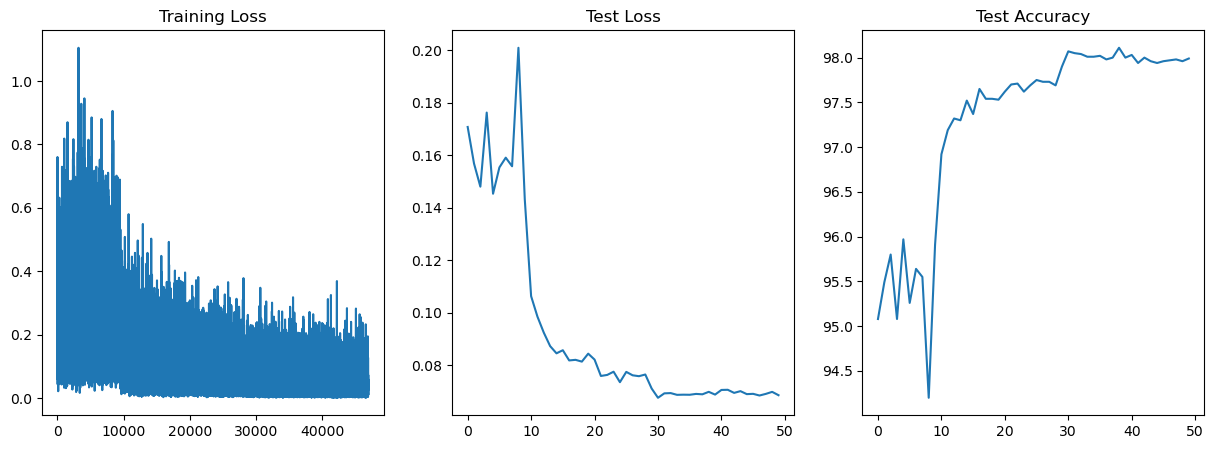

In [22]:
# Let's plot the training loss versus the number of iteration.
fig_height = 5
plt.figure(figsize=(3*fig_height, fig_height))

plt.subplot(1, 3, 1)
plt.plot(train_loss)
plt.title("Training Loss")

plt.subplot(1, 3, 2)
plt.plot(test_loss)
plt.title("Test Loss")

plt.subplot(1, 3, 3)
plt.plot(test_accuracy)
plt.title("Test Accuracy")

In [23]:
# Reloading the best model
saved_acc = max(Saved_models)
if saved_acc > best_accuracy:
    print(f'Loading from Saved models, accuracy: {saved_acc:.2f}%')
    best_model_dict = Saved_models[saved_acc]
else:
    print(f'Loading from last training session, accuracy: {best_accuracy:.2f}%')
    best_model_dict = best_model
    
model_mlp100.load_state_dict(best_model_dict)

Loading from last training session, accuracy: 98.11%


<All keys matched successfully>

# Test the Trained Model

Expected: 6. Predicted: 6.


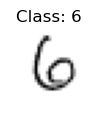

In [24]:
# Return the prediction
def predict(item):  # item: an item in the dataset
    model_mlp100.eval()
    # Extract features
    batch = [item]  # make a batch with single example
    tensor, target = collate_fn(batch)
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    target = target.to(device)
    output = model_mlp100(tensor)
    pred = get_likely_index(output)[0]   # indexing to get the prediction from batch
    return pred


# Run a prediction
select_index = 100
item = Test_dataset[select_index]
pred = predict(item)
print(f"Expected: {item[1]}. Predicted: {pred}.")
showItem(item)

# Save Model and Test Dataset

The **test dataset** and the prediction by the trained model is saved as the following dictionary:
- label_dict: {label: index}
- dataset_schema: structure of dataset items
- dataset: list of items
    - item: (label, label_index, predicted_index, feature_length, feature_vector)


The **trained model** is saved as the following dictionary:
- accuracy: percent accuracy as float
- correct_count: no. of correct prediction as integer
- Hparam: model hyper parameters as dictionary
- state_dict: The nn.Model.state_dict() of the trained model

In [25]:
# Computing accuracy and building the dataset records for exporting
correct_count = 0
dataset = []
for data in tqdm(Test_dataset):
    pred = predict(data)
    feature, target = collate_fn([data])   # as batch with single item
    feature, target = feature[0], target[0]
    item = [data[1], target.item(), pred.item(), len(feature), feature.tolist()]
    if pred==data[1]: correct_count += 1
    dataset.append(item)

accuracy = (100.0 * correct_count) / len(Test_dataset)

print('dataset:', len(dataset), '  Test_dataset:', len(Test_dataset))
print('correct_count:', correct_count)
print(f'accuracy: {accuracy:.2f}%')

  0%|          | 0/10000 [00:00<?, ?it/s]

dataset: 10000   Test_dataset: 10000
correct_count: 9811
accuracy: 98.11%


In [26]:
# Saving the Model with hyper-parameters and accuracy
save_path = './saved/trained_mlp100.pt'
model_dict = {
    'accuracy'     : accuracy,
    'correct_count': correct_count,
    'Hparam'       : Hparam,   # Hparam was defined while instantiating the model
    'state_dict'   : model_mlp100.state_dict()
}
torch.save(model_dict, save_path)
!ls -ltrh ./saved

total 69M
-rw-rw-r-- 1 makabir makabir  68M Jun 19 14:52 test_dataset.pt
-rw-rw-r-- 1 makabir makabir 353K Jun 19 15:25 trained_mlp100-97.91p.pt
-rw-rw-r-- 1 makabir makabir 353K Jun 19 15:44 trained_mlp100-98.17p.pt
-rw-rw-r-- 1 makabir makabir 353K Jun 20 17:41 trained_mlp100.pt


In [27]:
# Check the dataset records
item = dataset[0][:-1]  # Everything except feature_vector
feat_vec = dataset[0][-1]

print('item:', item)  
print('feat_vec:', type(feat_vec), len(feat_vec))

item: [7, 7, 7, 784]
feat_vec: <class 'list'> 784


In [28]:
# Build the dataset dictionary for exporting
label_dict = {label:label for label in Labels}
schema = "(label, label_index, predicted_index, feature_length, feature_vector)"
export_test = {
    'label_dict': label_dict,
    'dataset_schema': schema,
    'dataset': dataset
}

# Test exported dataset dictionary
keys = list(export_test.keys())
keys.remove('dataset')
for k in keys:
    print(k+':', export_test[k])

item = dataset[0][:-1]  # Everything except feature_vector
feat_vec = dataset[0][-1]
print('item:', item)  
print('feat_vec:', type(feat_vec), len(feat_vec))

label_dict: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
dataset_schema: (label, label_index, predicted_index, feature_length, feature_vector)
item: [7, 7, 7, 784]
feat_vec: <class 'list'> 784


In [29]:
# Save the dataset dictionary as PyTorch object
save_path = './saved/test_dataset.pt'
torch.save(export_test, save_path)
!ls -ltrh ./saved

total 69M
-rw-rw-r-- 1 makabir makabir 353K Jun 19 15:25 trained_mlp100-97.91p.pt
-rw-rw-r-- 1 makabir makabir 353K Jun 19 15:44 trained_mlp100-98.17p.pt
-rw-rw-r-- 1 makabir makabir 353K Jun 20 17:41 trained_mlp100.pt
-rw-rw-r-- 1 makabir makabir  68M Jun 20 17:41 test_dataset.pt


# Test prediction from Exported Dataset item

## Dataset related utilities

In [30]:
# Prints a dataset item
def print_dataitem(item):
    mstr = f"label: {item[0]}, label_index: {item[1]}, predicted_index: {item[2]}, feature_length: {item[3]},"
    mstr2 = f"feature_vector size: {len(item[4])}"
    print(mstr, mstr2)
    
    
# Given an item form the test_dataset, returns an example for predict() function
def make_example(data_item):
    feature = torch.tensor(data_item[4])
    return feature


# test prediction from dataset item
def predict_dataset(example, model=None):  # example: feature_vector
    model.eval()
    # Use the model to predict the label of the image
    feature = example.to(device)
    output = model(feature.unsqueeze(0))
    #print(output)
    pred = get_likely_index(output)[0]   # indexing to get the prediction from batch
    return pred.item()

## Load and Test the Saved Dataset and Model

In [31]:
# Load the model
model_path = './saved/trained_mlp100.pt'
model_dict = torch.load(model_path)
print(model_dict.keys())
print(model_dict['Hparam'].keys())
print(f"     accuracy: {model_dict['accuracy']}%")
print(f"correct_count: {model_dict['correct_count']}")

loaded_hparam = model_dict['Hparam']
loaded_model = MLP100(loaded_hparam['input_size'], loaded_hparam['num_classes']).to(device)
loaded_model.load_state_dict(model_dict['state_dict'])
print('\n', loaded_model)

dict_keys(['accuracy', 'correct_count', 'Hparam', 'state_dict'])
dict_keys(['input_size', 'num_classes'])
     accuracy: 98.11%
correct_count: 9811

 MLP100(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [32]:
# Load dataset and predict using an item from it
ds_path = './saved/test_dataset.pt'
loaded_ds = torch.load(ds_path)
item = loaded_ds['dataset'][0]
example = make_example(item)
pred = predict_dataset(example, model=loaded_model)
print('pred:',pred)
print_dataitem(item)

pred: 7
label: 7, label_index: 7, predicted_index: 7, feature_length: 784, feature_vector size: 784


# Concluding Remarks

Now you can continue to the next notebook to implement the model with basic matrix-vector operations without using any PyTorch ML/DL related features. Be careful with the **dataset schema**.